# Load and Visualize IBM Debater® Thematic Clustering of Sentences
This notebook relates to the IBM Debater® Thematic Clustering of Sentences dataset, which can be obtained for free from the IBM Developer [Data Asset Exchange](https://developer.ibm.com/exchanges/data/all/thematic-clustering-of-sentences/). The dataset contains 692 articles from Wikipedia, where the number of sections (clusters) in each article ranges from 5 to 12, and the number of sentences per article ranges from 17 to 1614.

The goal of these sequences of notebooks is to explore the dataset then use it to create a model that dynamically groups sentences by their main topics and themes. This could be used in for example an application that collects comments and feedback from customers of a company to help automatically organize the comments.

In this first notebook, we load, explore, clean and visualize the dataset. Then we save the cleaned dataset to the Watson Studio project as a data asset to be loaded in Part 2 - Model Development to evaluate a K-Means clustering model.


# Table of Contents

* [0. Prerequisite](#prerequisite)
* [1. Load Data](#1)   
    * [1.1 Download and Extract](#download)
    * [1.2 Preprocessing Data](#preprocess)
* [2. Data Visualization](#2)
* [3. Save the Cleaned Data](#3)
* [Authors](#authors)


<a class="anchor" id="prerequisite"></a>
## 0. Prerequisites

Before you run this notebook complete the following steps:
- Insert a project token
- Import required modules

#### Insert a project token

When you import this project from the Watson Studio Gallery, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the dataset from the project's resources:

* Click on `More -> Insert project token` in the top-right menu section

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

#### Import required modules

In [2]:
import pandas as pd
from pandas import read_excel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

## 1. Load Data <a class="anchor" id="1"></a>

### 1.1 Download and Extract <a class="anchor" id="download"></a>

First, we must download and extract the dataset. This notebook just requires one dataset which is from [IBM's Debater - Thematic Clustering of Sentences](https://developer.ibm.com/exchanges/data/all/thematic-clustering-of-sentences/) named `dataset.csv`. We use the below method to load and read this dataset that is already imported into the Watson Studio Project as a data asset.

The function below will help load the data asset file in the Watson Studio project.

In [3]:
# Define get data file function
def get_file_handle(fname):
    # Project data path for the raw data file
    data_path = project.get_file(fname)
    data_path.seek(0)
    return data_path

#### dataset.csv: 
This file contains 692 articles from Wikipedia, where the number of sections(clusters) in each article ranges from 5 to 12, and the number of sentences per article ranges from 17 to 1614. 

Each row in the dataset is a `Sentence` which is from a `SectionTitle` and each `SectionTitle` is from an `Article Title`. The column `Article Link` is the original source of the sentence.

In [4]:
# Define filename
DATA_PATH = 'dataset.csv'

# Use pandas to read the data 
data_path = get_file_handle(DATA_PATH)
clustering_df = pd.read_csv(data_path)
clustering_df.head()

,Article Title,Sentence,SectionTitle,Article Link
0,Moeller High School,"Moeller's student-run newspaper, The Crusader,...",School publications,https://en.wikipedia.org/wiki/Moeller_High_School
1,Moeller High School,"In 2008, The Crusader won First Place, the sec...",School publications,https://en.wikipedia.org/wiki/Moeller_High_School
2,Moeller High School,The Squire is a student literary journal that ...,School publications,https://en.wikipedia.org/wiki/Moeller_High_School
3,Moeller High School,Paul Keels - play-by-play announcer for Ohio S...,Notable alumni,https://en.wikipedia.org/wiki/Moeller_High_School
4,Moeller High School,Joe Uecker - Ohio State Senator (R-66) .,Notable alumni,https://en.wikipedia.org/wiki/Moeller_High_School


### 1.2 Preprocessing Data <a class="anchor" id="preprocess"></a>

In order for this data to be used to evaluate a clustering model, we need to assign them clusters. According to the readme file of the dataset (found in the original dataset zip [here](https://dax-cdn.cdn.appdomain.cloud/dax-thematic-clustering-of-sentences/1.0.2/thematic-clustering-of-sentences.tar.gz?cm_mc_uid=62879155279716117879192&cm_mc_sid_50200000=42851821611937048988&_ga=2.9971248.404611734.1611937060-1392747509.1611937060)), each cluster is each `SectionTitle`. That is, every sentence with the same section is in the same cluster. Thus, you can combine the `Article Title` and "SectionTitle" to get a group. 

We will add two columns in the dataset to more easily show the clusters by giving each cluster a unique label:
* `label` is the unique string,
* `label_id` is a unique number

In [5]:
clustering_df['label'] = clustering_df.apply(lambda row: row['Article Title'].strip().replace(" ", "_") + ":" + row['SectionTitle'].strip().replace(" ", "_"), axis=1)
clustering_df['label_id'] = clustering_df.label.astype('category').cat.codes
clustering_df.head()

,Article Title,Sentence,SectionTitle,Article Link,label,label_id
0,Moeller High School,"Moeller's student-run newspaper, The Crusader,...",School publications,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:School_publications,3414
1,Moeller High School,"In 2008, The Crusader won First Place, the sec...",School publications,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:School_publications,3414
2,Moeller High School,The Squire is a student literary journal that ...,School publications,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:School_publications,3414
3,Moeller High School,Paul Keels - play-by-play announcer for Ohio S...,Notable alumni,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:Notable_alumni,3413
4,Moeller High School,Joe Uecker - Ohio State Senator (R-66) .,Notable alumni,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:Notable_alumni,3413


We can create a dictionary mapping the label ID to the label name.

In [6]:
id_to_category = dict( enumerate(clustering_df.label.astype('category').cat.categories) )

If we take a look at the number of sentences that correspond to each cluster (label), we see that one cluster has a lot more sentences.

In [7]:
# One group has a lot more sentences. 
clustering_df.label_id.value_counts()

32      1308
27       164
30       126
4240      94
3013      91
        ... 
2695       3
5105       3
979        3
3026       3
1365       3
Name: label_id, Length: 5555, dtype: int64

In [8]:
id_to_category[32]

'1980_Birthday_Honours:United_Kingdom_and_Colonies'

We remove this cluster from our dataset because when we test our model in the second notebook, we want to keep groups together. Having this one very large group may not be an accurate representation of the real data.

In [9]:
# Remove rows in that top category
top_id = clustering_df.label_id.value_counts().index[0] 
df = clustering_df.loc[(clustering_df.label != id_to_category[top_id])]

In [10]:
df.head()

,Article Title,Sentence,SectionTitle,Article Link,label,label_id
0,Moeller High School,"Moeller's student-run newspaper, The Crusader,...",School publications,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:School_publications,3414
1,Moeller High School,"In 2008, The Crusader won First Place, the sec...",School publications,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:School_publications,3414
2,Moeller High School,The Squire is a student literary journal that ...,School publications,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:School_publications,3414
3,Moeller High School,Paul Keels - play-by-play announcer for Ohio S...,Notable alumni,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:Notable_alumni,3413
4,Moeller High School,Joe Uecker - Ohio State Senator (R-66) .,Notable alumni,https://en.wikipedia.org/wiki/Moeller_High_School,Moeller_High_School:Notable_alumni,3413


Next, we set the features to be `Sentence` which is all the text data we are interested in. We will be predicting the `label_id` with the model in the second notebook. Below we see that there are 5554 (1 removed) clusters and on average 8 sentences are in each cluster.

In [11]:
X = df.Sentence
y = df.label_id

print('Total data rows: ', len(X))
print('Unique groups: ', len(y.unique()))
print('Avgerage number of rows per group: ', clustering_df.label_id.value_counts().mean())

Total data rows:  44809
Unique groups:  5554
Avgerage number of rows per group:  8.301890189018902


To test a model, we will break this dataset into smaller datasets because in the real world, we likely would not want to have 5000 unique clusters. So we will split the data so that each set has about 5 clusters. To do this, we will randomly take 5000 of the 5554 clusters, then split this into 1000 sets. Now we have 1000 sets to test on (`list_of_groups`).

In [12]:
np.random.seed(42)  # get reproducible results
number_of_groups = 1000
sampled_categories = np.random.choice(y.unique(), size=5000)
list_of_groups = np.split(sampled_categories, number_of_groups)  # 5 categories in each group

In [13]:
# Convert list_of_groups to ad DataFrame to save to the project
groups_of_themes = pd.DataFrame(pd.Series(np.array(list_of_groups).tolist()), columns=['group'])
groups_of_themes.head()

,group
0,"[2822, 1492, 2014, 4508, 4393]"
1,"[535, 2896, 3550, 1670, 2837]"
2,"[739, 659, 1015, 1362, 3938]"
3,"[4167, 4753, 1516, 1386, 1705]"
4,"[3029, 3826, 3057, 3969, 5299]"


## 2. Data Visualization <a class="anchor" id="2"></a>

Each theme (cluster) has about 8 sentences on average.

In [14]:
df.label_id.value_counts().describe()

count    5554.000000
mean        8.067879
std         8.506450
min         3.000000
25%         4.000000
50%         5.000000
75%         9.000000
max       164.000000
Name: label_id, dtype: float64

We want a relatively uniform distribution of themes since we want roughly equal sized cluster data to set. In the below histogram, it appears that we do have a uniform distribution.

Text(0.5, 1.0, 'Distribution of Themes')

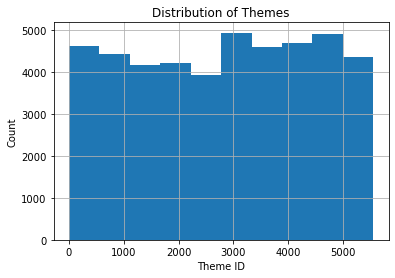

In [15]:
ax = df.label_id.hist()
ax.set_xlabel('Theme ID')
ax.set_ylabel('Count')
ax.set_title('Distribution of Themes')

Next, we look at how many words are included in each theme (`label`). On average, the themes are 4 words long and the longest theme is 22 words. Fifty percent of themes are four or less words.

In [16]:
df['label'].str.split('_').apply(len).describe()

count    44809.000000
mean         4.396148
std          2.577010
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         20.000000
Name: label, dtype: float64

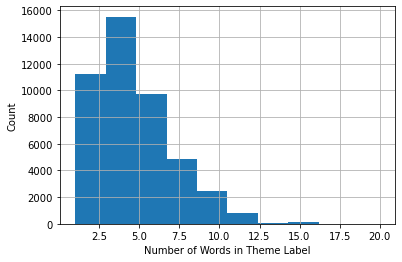

In [17]:
ax = df['label'].str.split('_').apply(len).hist()
ax.set_xlabel('Number of Words in Theme Label')
ax.set_ylabel('Count');

On average, the sentences used have about 21 words. To test our model in the second notebook, we would not want all really short or really long sentences since that is probably not likely to be seen in real comments. About 21 words is aligned with a normal average in a sentence. The histogram below also shows that the number of words is skewed to the right (more sentences are shorter rather than longer).

In [18]:
df['Sentence'].str.split().apply(len).describe()

count    44809.000000
mean        21.846995
std          9.967591
min          5.000000
25%         14.000000
50%         20.000000
75%         28.000000
max         50.000000
Name: Sentence, dtype: float64

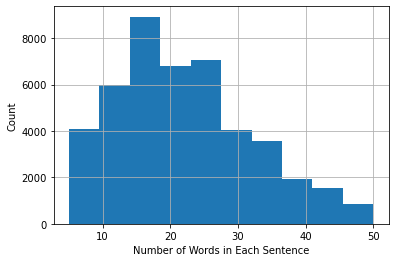

In [19]:
ax = df['Sentence'].str.split().apply(len).hist()
ax.set_xlabel('Number of Words in Each Sentence')
ax.set_ylabel('Count');

## 3. Save the Cleaned Data <a class="anchor" id="3"></a>

Finally, we save the cleaned dataset as a Project asset for later re-use. You should see an output like the one below if successful:

```
{'file_name': 'themes.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdebaterthematicclusteringofsen...',
 'asset_id': '...'}
```

and

```
{'file_name': 'groups_of_themes.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdebaterthematicclusteringofsen...',
 'asset_id': '...'}
```

**Note**: In order for this step to work, your project token (see the first cell of this notebook) must have `Editor` role. By default this will overwrite any existing file.

In [20]:
project.save_data("themes.csv", df.to_csv(index=False, float_format='%g'), overwrite=True)

{'file_name': 'themes.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdebaterthematicclusteringofsen-donotdelete-pr-wsojkqqhzamftm',
 'asset_id': '55b504c4-d01f-477e-909b-ac5326d4b4e3'}

In [21]:
project.save_data("groups_of_themes.csv", groups_of_themes.to_csv(index=False), overwrite=True)

{'file_name': 'groups_of_themes.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdebaterthematicclusteringofsen-donotdelete-pr-wsojkqqhzamftm',
 'asset_id': '7a911454-0b9c-49f1-af76-6584d5f07f2f'}


### Next steps

- Close this notebook.
- Open the `Part 2 - Model Development` notebook to explore the cleaned dataset.



<a id="authors"></a> 
### Authors
This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).

Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>